# **Brain Tumor Radiogenomic Classification (Swin Vision Transformer Model Based)**

### 1) Data Visualization and Analysis

In [1]:
import os
import re
import json
import glob
import time
import random
import collections

import numpy as np
import pandas as pd
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import functional as torch_functional
import torch.optim as optim
from torch.utils import data as torch_data
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data.dataloader import default_collate
import torchvision.transforms as transforms

from sklearn import model_selection as sk_model_selection
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

In [2]:
torch.cuda.empty_cache()

In [3]:
!pip install ../input/einops-030/einops-0.3.0-py2.py3-none-any.whl

from einops import rearrange, repeat

Processing /kaggle/input/einops-030/einops-0.3.0-py2.py3-none-any.whl


In [4]:
out_dir = '/kaggle/working/preprocessed-rsna-miccai-brain-tumor-radiogenomic-classification/'

In [5]:
root_dir = '../input/rsna-miccai-brain-tumor-radiogenomic-classification/'

df = pd.read_csv(root_dir + 'train_labels.csv')
df

,BraTS21ID,MGMT_value
0,0,1
1,2,1
2,3,0
3,5,1
4,6,1
...,...,...
580,1005,1
581,1007,1
582,1008,1
583,1009,0


In [6]:
df_train, df_valid = sk_model_selection.train_test_split (
    df,
    test_size = 0.2,
    random_state = 9,
    stratify = df['MGMT_value'],
)

In [7]:
df_train.head()

,BraTS21ID,MGMT_value
326,481,0
141,212,1
39,61,0
144,217,0
545,799,0


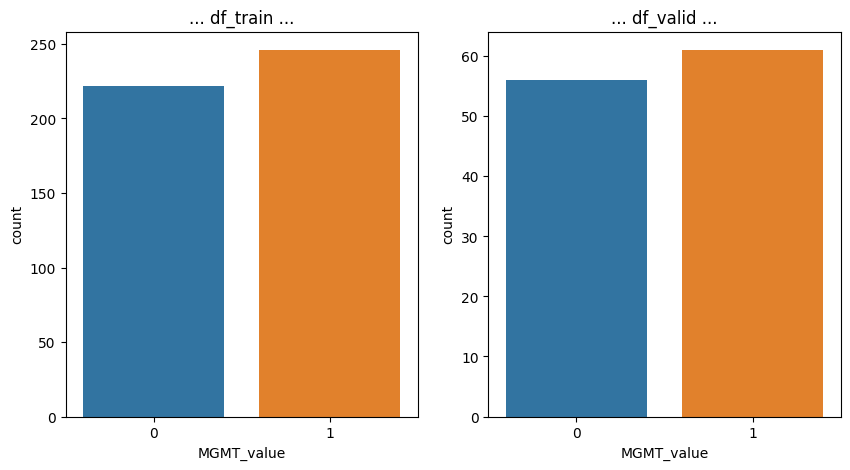

In [8]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("... df_train ...")
sns.countplot(data=df_train, x="MGMT_value");

plt.subplot(1, 2, 2)
plt.title("... df_valid ...")
sns.countplot(data=df_valid, x="MGMT_value");

In [9]:
mri_types = ['FLAIR', 'T1w', 'T1wCE', 'T2w']

def refine(dataframe):
    dataframe['BraTS21ID_full'] = [str(dataframe['BraTS21ID'][index]).zfill(5) for index in dataframe.index]
    for i in range(len(mri_types)):
        mri = mri_types[i]
        dataframe[mri] = dataframe['BraTS21ID_full'].apply(lambda file_id: root_dir+'train/'+file_id+'/'+mri+'/')
    dataframe = dataframe.set_index("BraTS21ID")
    return dataframe

df_train = refine(df_train)
df_valid = refine(df_valid)

In [10]:
df_train.head()

,MGMT_value,BraTS21ID_full,FLAIR,T1w,T1wCE,T2w
BraTS21ID,,,,,,
481,0,00481,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...
212,1,00212,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...
61,0,00061,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...
217,0,00217,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...
799,0,00799,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...


In [11]:
df_valid.head()

,MGMT_value,BraTS21ID_full,FLAIR,T1w,T1wCE,T2w
BraTS21ID,,,,,,
563,0,00563,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...
195,0,00195,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...
28,1,00028,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...
608,1,00608,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...
21,0,00021,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...


In [12]:
df_train['BraTS21ID_full'][481]

'00481'

In [13]:
df_train['FLAIR'][481]

'../input/rsna-miccai-brain-tumor-radiogenomic-classification/train/00481/FLAIR/'

In [14]:
def load_sample(path):
    dicom = pydicom.read_file(path)
    data = dicom.pixel_array
    
    # Normalize pixel values
    data = data - np.min(data)
    
    if np.max(data) != 0:
        # Normalize pixel values to scale them in the range of [0, 1]
        data = data / np.max(data)
    # Scale the pixel values to get in the range of [0, 255]    
    data = (data * 255).astype(np.uint8)
    return data

def visualize_sample(ID, MGMT_value, select):
    plt.figure(figsize=(16, 6))
    ID_path = os.path.join(root_dir + "train/", ID)
#     print(ID_path)
    
    for i, mri in enumerate(mri_types, 1):
        mri_paths = sorted(glob.glob(os.path.join(ID_path, mri, "*")), key=lambda var:[int(x) if x.isdigit() else x for x in re.findall(r'[^0-9]|[0-9]+', var)])
#         print(mri_paths)

        # Access the middle Images among all the images present in the list
        path = mri_paths[int(len(mri_paths)*select)]
#         print(path)
        data = load_sample(path)
    
        plt.subplot(1, 4, i)
        plt.imshow(data, cmap="gray")
        plt.title(f"{mri}", fontsize=10)
        plt.axis("off")
    
    plt.suptitle(f"BraTS21_ID: {int(ID)}        MGMT_value: {MGMT_value}", fontsize=12)
    plt.show()

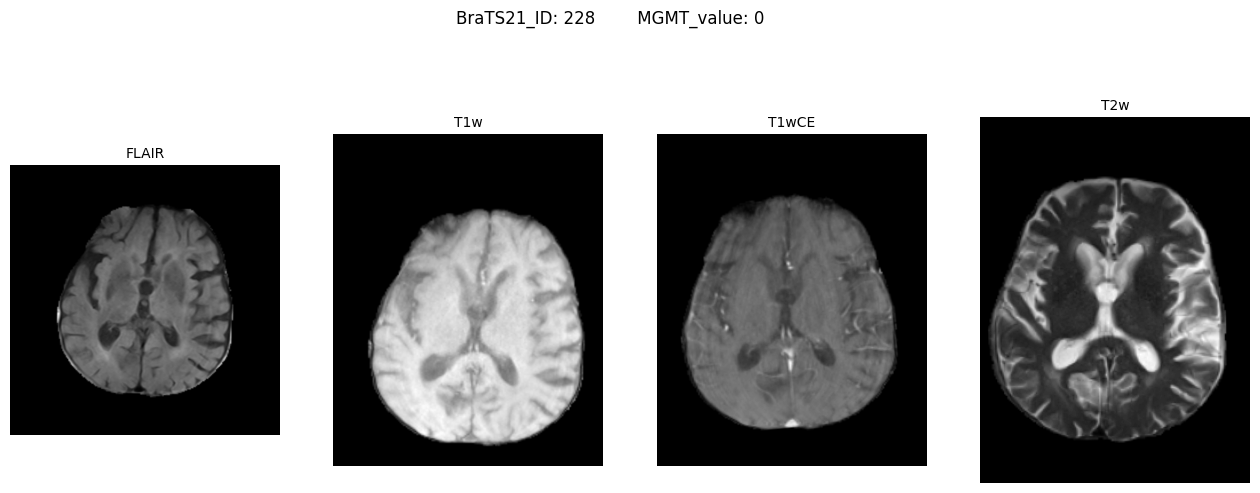

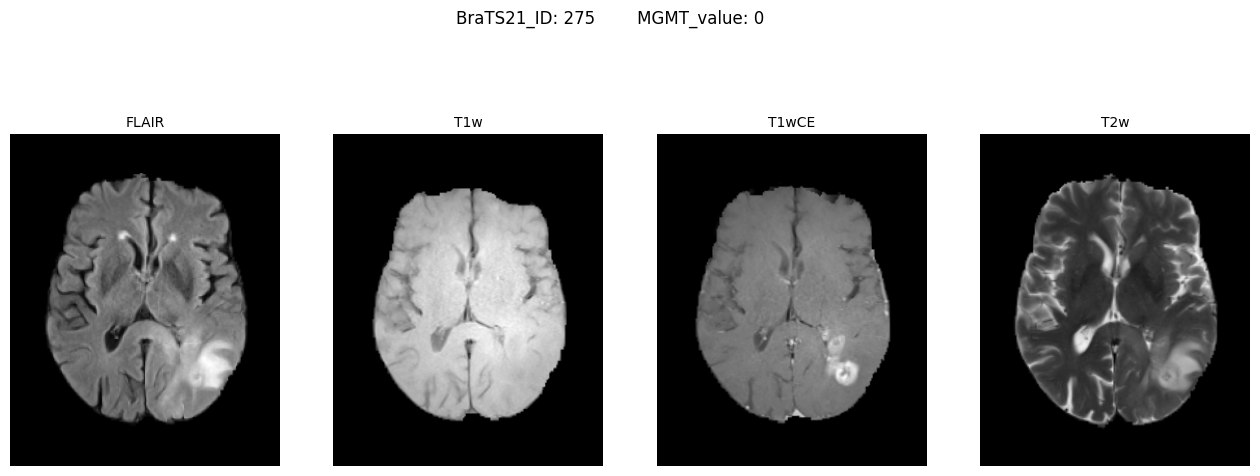

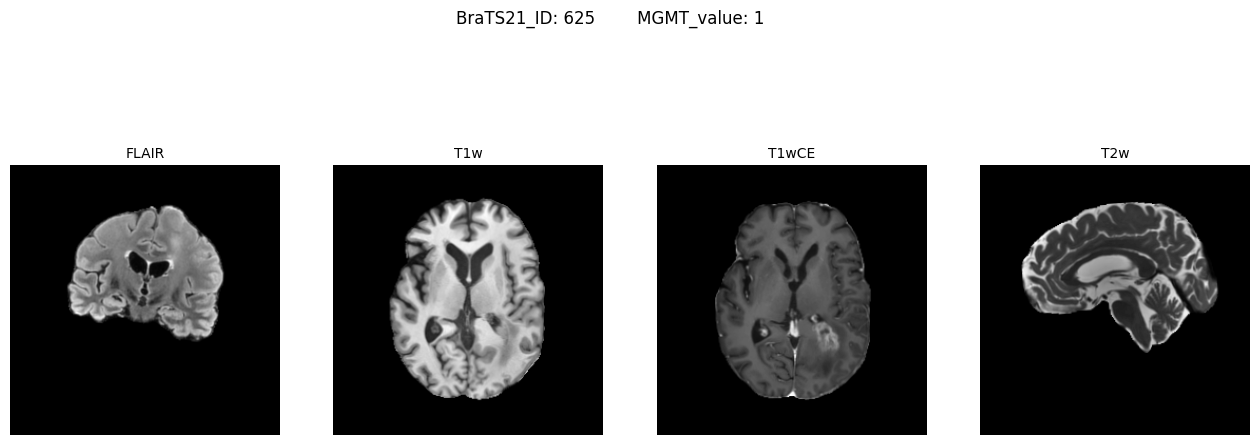

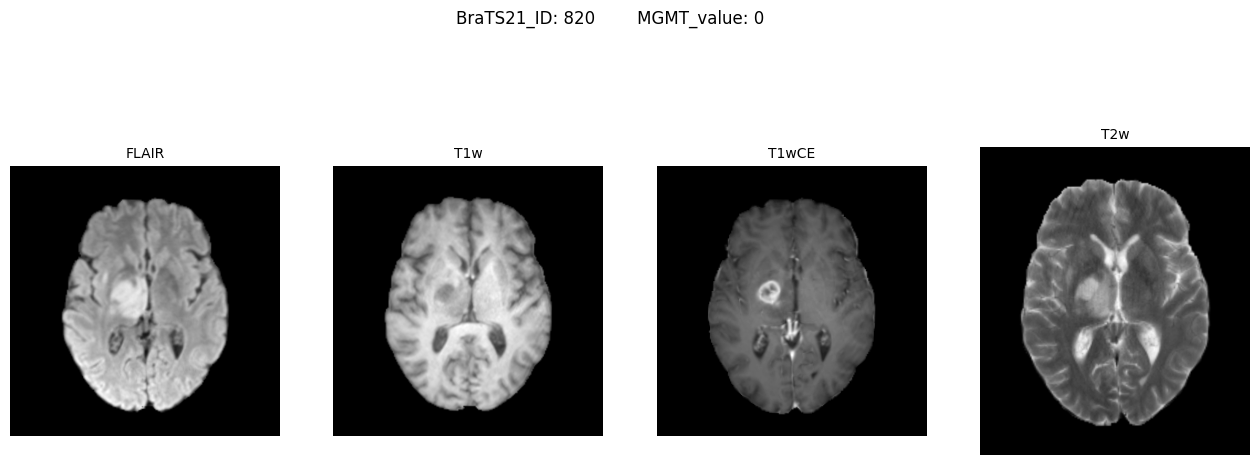

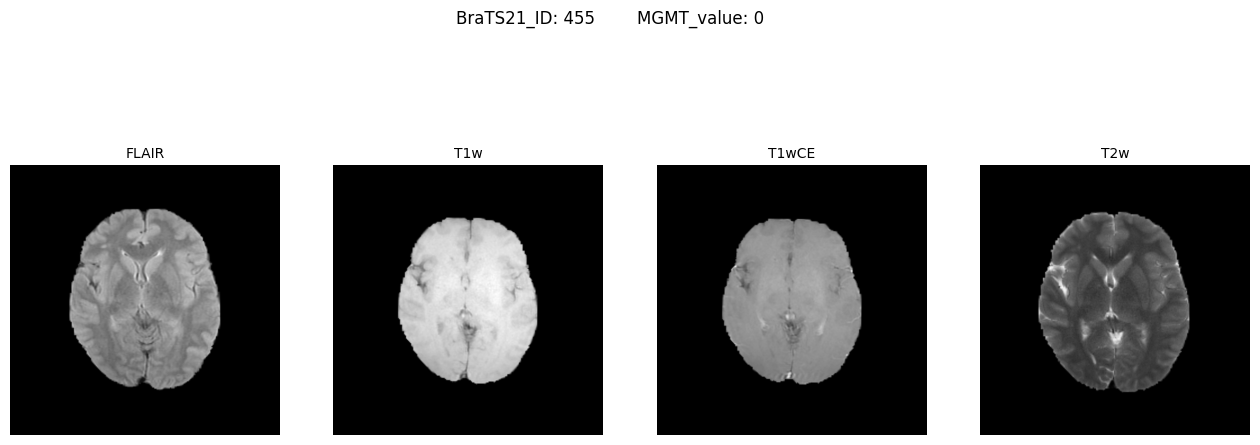

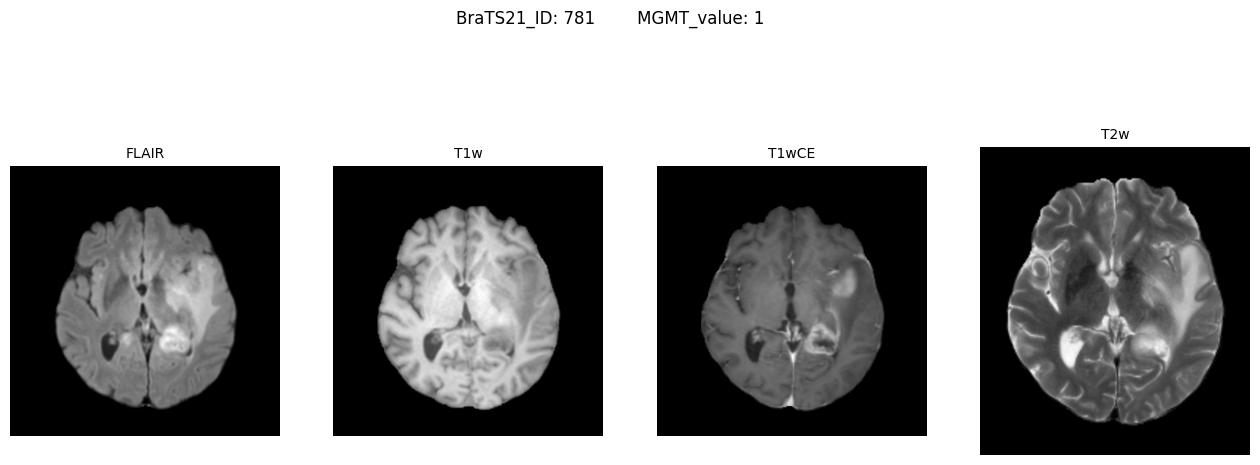

In [15]:
# Sample
for i in random.sample(range(df_train.shape[0]), 6):
    ID = df_train.iloc[i]["BraTS21ID_full"]
    MGMT_value = df_train.iloc[i]["MGMT_value"]
    visualize_sample(ID, MGMT_value, select=0.5)

### 2) Data Augmentation & Loading

In [16]:
IMG_SIZE = 256
NUM_IMGS = 64

In [17]:
def load_dicom_image(path, img_size=IMG_SIZE, voi_lut=True, rotate=0, fix_monochrome=True):
    dicom = pydicom.read_file(path)
    data = dicom.pixel_array
    
    if voi_lut:
        data = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        data = dicom.pixel_array
        
    if rotate > 0:
        rot_choices = [0, cv2.ROTATE_90_CLOCKWISE, cv2.ROTATE_90_COUNTERCLOCKWISE, cv2.ROTATE_180]
        data = cv2.rotate(data, rot_choices[rotate])
          
    data = cv2.resize(data, (img_size, img_size))
    return data

def load_dicom_images_3d(scan_id, num_imgs=NUM_IMGS, img_size=IMG_SIZE, mri="FLAIR", dataframe=df_train, rotate=0):
    files = sorted(glob.glob(f"{dataframe[mri][int(scan_id)]}/*.dcm"), key=lambda var:[int(x) if x.isdigit() else x for x in re.findall(r'[^0-9]|[0-9]+', var)])
    
    middle = len(files)//2
    imgs = num_imgs//2
    
    p1 = max(0, middle - imgs)
    p2 = min(len(files), middle + imgs)
    
    img3d = np.stack([load_dicom_image(f, rotate=rotate) for f in files[p1:p2]]).T
        
    if img3d.shape[-1] < num_imgs:
        n_zero = np.zeros((img_size, img_size, num_imgs - img3d.shape[-1]))
        img3d = np.concatenate((img3d, n_zero), axis = -1)
        
    if np.min(img3d) < np.max(img3d):
        img3d = img3d - np.min(img3d)
        img3d = img3d / np.max(img3d)

    return np.expand_dims(img3d, 0)

a = load_dicom_images_3d("00481")
print(a.shape)
print(np.min(a), np.max(a), np.mean(a), np.median(a))

(1, 256, 256, 64)
0.0 1.0 0.05419003281395742 0.00012306291639827978


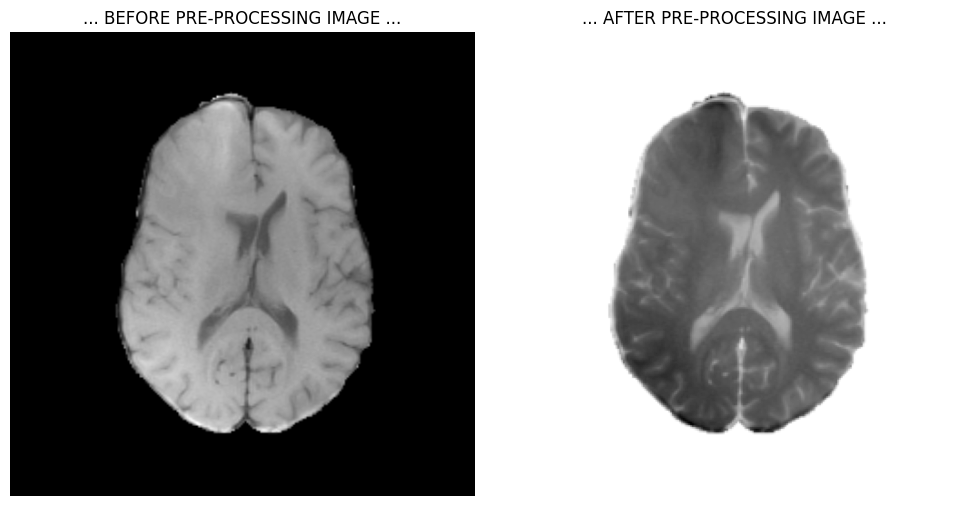

In [18]:
dicom = pydicom.read_file(root_dir + "train/00481/T1w/Image-18.dcm")
data = dicom.pixel_array

data_after = load_dicom_image(root_dir + "train/00481/T1w/Image-18.dcm" )

plt.figure(figsize=(10,5))

plt.subplot(1, 2, 1)
plt.title("... BEFORE PRE-PROCESSING IMAGE ...")
plt.imshow(data.astype("float32") / np.max(data), cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("... AFTER PRE-PROCESSING IMAGE ...")
plt.imshow(data_after.astype("float32") / np.max(data_after), cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

In [19]:
class BraTSDataset(Dataset):
    def __init__(self, path, target=None, mri=None, label_smoothing=0.01, dataframe=df_train, augment=False):
        self.path = path
        self.target = target
        self.mri = mri
        self.label_smoothing = label_smoothing
        self.dataframe = dataframe
        self.augment = augment
        
    def __len__(self):
        return len(self.path)
    
    def __getitem__(self, index):
        scan_id = self.path[index]
        if self.target is None:
            images_3d = load_dicom_images_3d(scan_id, mri=self.mri[index], dataframe=self.dataframe)
        else:
            if self.augment:
                rotation = np.random.randint(0,4)
            else:
                rotation = 0
                
            images_3d = load_dicom_images_3d(scan_id, mri=self.mri[index], dataframe=self.dataframe, rotate=rotation)
        
        images_3d = torch.tensor(images_3d, dtype=torch.float)
        if self.target is None:
            return {"image": images_3d, "id": scan_id}
        else:
            target = torch.tensor(abs(self.target[index]-self.label_smoothing), dtype=torch.float) 
            return {"image": images_3d, "target": target}

### 3) Vision Transformer Model

In [20]:
class PatchEmbedding(nn.Module):
    def __init__(self, img_size, patch_size, in_channels, dim):
        super(PatchEmbedding, self).__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.in_channels = in_channels
        self.dim = dim
        
        self.num_patches = (img_size // patch_size) ** 2
        self.proj = nn.Conv2d(self.in_channels, dim, kernel_size=patch_size, stride=patch_size)
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.patch_tokens = nn.Parameter(torch.randn(1, self.num_patches + 1, dim))

    def forward(self, x):
#         print(x.shape)
        x = x.squeeze(1)
#         print(x.shape)
        x = x.permute(0, 3, 1, 2)  # [batch_size, height, width, channels] -> [batch_size, channels, height, width]
        
        x = self.proj(x)
        x = rearrange(x, 'b d h w -> b (h w) d')
        cls_tokens = self.cls_token.expand(x.shape[0], -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.patch_tokens[:, :x.size(1), :]
        return x

In [21]:
class PositionalEmbedding(nn.Module):
    def __init__(self, img_size, patch_size, dim, emb_dropout=0.1):
        super(PositionalEmbedding, self).__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.dim = dim
        
        num_patches = (img_size // patch_size) ** 2
        self.pos_embed = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.dropout = nn.Dropout(emb_dropout)

    def forward(self, x):
        x += self.pos_embed
        return self.dropout(x)

In [22]:
class SwinTransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, mlp_ratio=4., qkv_bias=True, qk_scale=None, dropout=0.0, attention_dropout=0.0, droppath=0.1):
        super(SwinTransformerBlock, self).__init__()
        
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = SwinAttention(embed_dim, num_heads, qkv_bias, qk_scale, dropout, attention_dropout, droppath)
        self.drop_path = DropPath(droppath) if droppath > 0.0 else nn.Identity()
        self.dropout = nn.Dropout(0.2)
        
        self.norm2 = nn.LayerNorm(embed_dim)
        mlp_hidden_dim = int(embed_dim * mlp_ratio)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, mlp_hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(mlp_hidden_dim, embed_dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        x = x + self.drop_path(self.attn(self.norm1(x)))
        x = x + self.drop_path(self.mlp(self.norm2(x)))
        return x

In [23]:
class SwinAttention(nn.Module):
    def __init__(self, embed_dim, num_heads, qkv_bias=True, qk_scale=None, dropout=0.0, attention_dropout=0.0, droppath=0.1):
        super(SwinAttention, self).__init__()
        
        self.num_heads = num_heads
        head_dim = embed_dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5
        
        self.qkv = nn.Linear(embed_dim, embed_dim * 3, bias=qkv_bias)
        self.attn_dropout = nn.Dropout(attention_dropout)
        self.proj = nn.Linear(embed_dim, embed_dim)
        self.proj_dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_dropout(attn)
        
        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_dropout(x)
        
        return x

In [24]:
class DropPath(nn.Module):
    def __init__(self, drop_prob=None):
        super(DropPath, self).__init__()
        self.drop_prob = drop_prob

    def forward(self, x):
        if self.drop_prob == 0. or not self.training:
            return x
        keep_prob = 1 - self.drop_prob
        shape = (x.shape[0],) + (1,) * (x.ndim - 1)
        random_tensor = keep_prob + torch.rand(shape, dtype=x.dtype, device=x.device)
        random_tensor.floor_()
        output = x / keep_prob * random_tensor
        return output

In [25]:
class SwinTransformer(nn.Module):
    def __init__(self, img_size=IMG_SIZE, patch_size=4, in_channels=64, num_classes=1, embed_dim=96, depth=12, num_heads=8, mlp_ratio=4., qkv_bias=True, qk_scale=None, dropout=0.0, attention_dropout=0.0, droppath=0.1):
        super(SwinTransformer, self).__init__()
        
        self.patch_embed = PatchEmbedding(img_size, patch_size, in_channels, embed_dim)
        self.pos_embed = PositionalEmbedding(img_size, patch_size, embed_dim)
        
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                nn.LayerNorm(embed_dim),
                SwinTransformerBlock(embed_dim, num_heads, mlp_ratio, qkv_bias, qk_scale, dropout, attention_dropout, droppath)
            ]))
        
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        x = self.patch_embed(x)
        x = self.pos_embed(x)
        
        for norm, block in self.layers:
            x = block(norm(x))
        
        x = self.norm(x)
        x = x.mean(dim=1)
        x = self.head(x)
        
        return x

### 4) Training

In [26]:
class Trainer:
    def __init__(self, model, device, optimizer, criterion):
        self.model = model
        self.device = device
        self.optimizer = optimizer
        self.criterion = criterion
        self.best_valid_score = np.inf
        self.n_patience = 0
        self.lastmodel = None
        
    def fit(self, epochs, train_loader, valid_loader, save_path, patience):
        for n_epoch in range(1, epochs + 1):
            self.info_message("EPOCH: {}", n_epoch)
            
            train_loss, train_time = self.train_epoch(train_loader)
            valid_loss, valid_auc, valid_time = self.valid_epoch(valid_loader)
            
            self.info_message("[Train Epoch: {}] loss: {: .4f}, time: {:.2f} s", n_epoch, train_loss, train_time)
            self.info_message("[Valid Epoch: {}] loss: {: .4f}, auc: {:.4f}, time: {:.2f} s", n_epoch, valid_loss, valid_auc, valid_time)
    
            if self.best_valid_score > valid_loss:
                self.save_model(n_epoch, save_path, valid_loss, valid_auc)
                self.info_message("AUC improved from {:.4f} to {:.4f}, Saved model to '{}'", self.best_valid_score, valid_auc, self.lastmodel)
                self.best_valid_score = valid_loss
                self.n_patience = 0
            else:
                self.n_patience += 1
            if self.n_patience >= patience:
                self.info_message("\n Valid AUC didn't improve last {} epochs",patience)
                break
    
    def train_epoch(self, train_loader):
        self.model.train()
        t = time.time()
        sum_loss = 0
        
        for step, batch in enumerate(train_loader, 1):
            X = batch["image"].to(self.device)
            targets = batch["target"].to(self.device)
            self.optimizer.zero_grad()
            outputs = self.model(X)
            
#             print("Outputs shape:", outputs.shape)
            outputs = outputs.view_as(targets)
#             print("Targets shape:", targets.shape) 
            
            loss = self.criterion(outputs, targets)
            loss.backward()
            sum_loss += loss.detach().item()
            self.optimizer.step()    
            
            message = 'Train Step {}/{}, train_loss: {:.4f}'
            self.info_message(message, step, len(train_loader), sum_loss/step, end="\r")
        
        return sum_loss/len(train_loader), int(time.time() - t)
    
    def valid_epoch(self, valid_loader):
        self.model.eval()
        t = time.time()
        sum_loss = 0
        y_all = []
        outputs_all = []
        
        for step, batch in enumerate(valid_loader, 1):
            with torch.no_grad():
                X = batch["image"].to(self.device)
                targets = batch["target"].to(self.device)
                self.optimizer.zero_grad()
                outputs = self.model(X)
                
#                 print("Outputs shape:", outputs.shape)
                outputs = outputs.view_as(targets)
#                 print("Targets shape:", targets.shape) 

                loss = self.criterion(outputs, targets)
                sum_loss += loss.detach().item()
                y_all.extend(batch["target"].tolist())
                outputs_all.extend(torch.sigmoid(outputs).tolist())

            message = 'Valid Step {}/{}, valid_loss: {:.4f}'
            self.info_message(message, step, len(valid_loader), sum_loss/step, end="\r")
            
        y_all = [1 if x > 0.5 else 0 for x in y_all]
        auc = roc_auc_score(y_all, outputs_all)
        return sum_loss/len(valid_loader), auc, int(time.time() - t)
    
    def save_model(self, n_epoch, save_path, loss, auc):
        self.lastmodel = f"{save_path}-best.pth"
        torch.save(
            {
                "model_state_dict": self.model.state_dict(),
                "optimizer_state_dict": self.optimizer.state_dict(),
                "best_valid_score": self.best_valid_score,
                "n_epoch": n_epoch,
            },
            self.lastmodel,
        )
    
    @staticmethod
    def info_message(message, *args, end="\n"):
        print(message.format(*args), end=end)

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train(df_train, df_valid, mri):
    if mri == "all":
        train_list = []
        valid_list = []
        for mri in mri_types:
            df_train.loc[:,"MRI_Type"] = mri
            train_list.append(df_train.copy())
            df_valid.loc[:,"MRI_Type"] = mri
            valid_list.append(df_valid.copy())
        df_train = pd.concat(train_list)
        df_valid = pd.concat(valid_list)
    else:
        df_train.loc[:,"MRI_Type"] = mri
        df_valid.loc[:,"MRI_Type"] = mri
    
    print(df_train.shape, df_valid.shape)
    display(df_train.head())
    
    train_data_retrieve = BraTSDataset(df_train["BraTS21ID_full"].values, df_train["MGMT_value"].values, df_train["MRI_Type"].values, dataframe=df_train, augment=True)
    valid_data_retrieve = BraTSDataset(df_valid["BraTS21ID_full"].values, df_valid["MGMT_value"].values, df_valid["MRI_Type"].values, dataframe=df_valid)
    
    train_loader = DataLoader(train_data_retrieve, batch_size=4, shuffle=True, num_workers=4, pin_memory=True)
    valid_loader = DataLoader(valid_data_retrieve, batch_size=4, shuffle=False, num_workers=4, pin_memory=True)
    
    # Initialize SwinTransformer
    model = SwinTransformer(img_size=IMG_SIZE, patch_size=32, in_channels=64, num_classes=1, depth=16)
    model.to(device)
    
#     optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)

#     criterion = F.binary_cross_entropy_with_logits
    criterion = nn.BCEWithLogitsLoss()

    trainer = Trainer(model, device, optimizer, criterion)
    history = trainer.fit(10, train_loader, valid_loader, f"{mri}", 10)
    
    return trainer.lastmodel

modelfiles = None
if not modelfiles:
    modelfiles = [train(df_train, df_valid, m) for m in mri_types]
    print(modelfiles)

(468, 7) (117, 7)


,MGMT_value,BraTS21ID_full,FLAIR,T1w,T1wCE,T2w,MRI_Type
BraTS21ID,,,,,,,
481,0,00481,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,FLAIR
212,1,00212,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,FLAIR
61,0,00061,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,FLAIR
217,0,00217,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,FLAIR
799,0,00799,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,FLAIR


EPOCH: 1
[Train Epoch: 1] loss:  0.7384, time: 114.00 s
[Valid Epoch: 1] loss:  0.6933, auc: 0.5824, time: 30.00 s
AUC improved from inf to 0.5824, Saved model to 'FLAIR-best.pth'
EPOCH: 2
[Train Epoch: 2] loss:  0.7089, time: 58.00 s
[Valid Epoch: 2] loss:  0.7218, auc: 0.5694, time: 13.00 s
EPOCH: 3
[Train Epoch: 3] loss:  0.7030, time: 57.00 s
[Valid Epoch: 3] loss:  0.6934, auc: 0.5581, time: 13.00 s
EPOCH: 4
[Train Epoch: 4] loss:  0.7042, time: 56.00 s
[Valid Epoch: 4] loss:  0.7016, auc: 0.5688, time: 14.00 s
EPOCH: 5
[Train Epoch: 5] loss:  0.7049, time: 58.00 s
[Valid Epoch: 5] loss:  0.6931, auc: 0.5539, time: 13.00 s
AUC improved from 0.6933 to 0.5539, Saved model to 'FLAIR-best.pth'
EPOCH: 6
[Train Epoch: 6] loss:  0.6951, time: 57.00 s
[Valid Epoch: 6] loss:  0.7077, auc: 0.5591, time: 13.00 s
EPOCH: 7
[Train Epoch: 7] loss:  0.7035, time: 56.00 s
[Valid Epoch: 7] loss:  0.6934, auc: 0.5591, time: 13.00 s
EPOCH: 8
[Train Epoch: 8] loss:  0.7011, time: 56.00 s
[Valid Epoch:

,MGMT_value,BraTS21ID_full,FLAIR,T1w,T1wCE,T2w,MRI_Type
BraTS21ID,,,,,,,
481,0,00481,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,T1w
212,1,00212,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,T1w
61,0,00061,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,T1w
217,0,00217,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,T1w
799,0,00799,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,T1w


EPOCH: 1
[Train Epoch: 1] loss:  0.7282, time: 89.00 s
[Valid Epoch: 1] loss:  0.7006, auc: 0.5350, time: 24.00 s
AUC improved from inf to 0.5350, Saved model to 'T1w-best.pth'
EPOCH: 2
[Train Epoch: 2] loss:  0.7128, time: 48.00 s
[Valid Epoch: 2] loss:  0.6959, auc: 0.5331, time: 12.00 s
AUC improved from 0.7006 to 0.5331, Saved model to 'T1w-best.pth'
EPOCH: 3
[Train Epoch: 3] loss:  0.7021, time: 48.00 s
[Valid Epoch: 3] loss:  0.7029, auc: 0.5259, time: 11.00 s
EPOCH: 4
[Train Epoch: 4] loss:  0.7055, time: 46.00 s
[Valid Epoch: 4] loss:  0.6952, auc: 0.5243, time: 11.00 s
AUC improved from 0.6959 to 0.5243, Saved model to 'T1w-best.pth'
EPOCH: 5
[Train Epoch: 5] loss:  0.6980, time: 46.00 s
[Valid Epoch: 5] loss:  0.6990, auc: 0.5624, time: 11.00 s
EPOCH: 6
[Train Epoch: 6] loss:  0.6962, time: 47.00 s
[Valid Epoch: 6] loss:  0.6960, auc: 0.5584, time: 11.00 s
EPOCH: 7
[Train Epoch: 7] loss:  0.6940, time: 46.00 s
[Valid Epoch: 7] loss:  0.6943, auc: 0.5527, time: 12.00 s
AUC imp

,MGMT_value,BraTS21ID_full,FLAIR,T1w,T1wCE,T2w,MRI_Type
BraTS21ID,,,,,,,
481,0,00481,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,T1wCE
212,1,00212,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,T1wCE
61,0,00061,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,T1wCE
217,0,00217,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,T1wCE
799,0,00799,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,T1wCE


EPOCH: 1
[Train Epoch: 1] loss:  0.7392, time: 103.00 s
[Valid Epoch: 1] loss:  0.7032, auc: 0.5034, time: 28.00 s
AUC improved from inf to 0.5034, Saved model to 'T1wCE-best.pth'
EPOCH: 2
[Train Epoch: 2] loss:  0.7063, time: 69.00 s
[Valid Epoch: 2] loss:  0.7115, auc: 0.5562, time: 21.00 s
EPOCH: 3
[Train Epoch: 3] loss:  0.7056, time: 64.00 s
[Valid Epoch: 3] loss:  0.6947, auc: 0.5547, time: 13.00 s
AUC improved from 0.7032 to 0.5547, Saved model to 'T1wCE-best.pth'
EPOCH: 4
[Train Epoch: 4] loss:  0.7046, time: 51.00 s
[Valid Epoch: 4] loss:  0.6966, auc: 0.5553, time: 13.00 s
EPOCH: 5
[Train Epoch: 5] loss:  0.6968, time: 50.00 s
[Valid Epoch: 5] loss:  0.6938, auc: 0.5414, time: 12.00 s
AUC improved from 0.6947 to 0.5414, Saved model to 'T1wCE-best.pth'
EPOCH: 6
[Train Epoch: 6] loss:  0.6969, time: 52.00 s
[Valid Epoch: 6] loss:  0.7046, auc: 0.5509, time: 12.00 s
EPOCH: 7
[Train Epoch: 7] loss:  0.7000, time: 51.00 s
[Valid Epoch: 7] loss:  0.7012, auc: 0.5523, time: 13.00 s


,MGMT_value,BraTS21ID_full,FLAIR,T1w,T1wCE,T2w,MRI_Type
BraTS21ID,,,,,,,
481,0,00481,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,T2w
212,1,00212,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,T2w
61,0,00061,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,T2w
217,0,00217,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,T2w
799,0,00799,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,T2w


EPOCH: 1
[Train Epoch: 1] loss:  0.7303, time: 109.00 s
[Valid Epoch: 1] loss:  0.6930, auc: 0.4275, time: 28.00 s
AUC improved from inf to 0.4275, Saved model to 'T2w-best.pth'
EPOCH: 2
[Train Epoch: 2] loss:  0.7021, time: 56.00 s
[Valid Epoch: 2] loss:  0.6998, auc: 0.5290, time: 14.00 s
EPOCH: 3
[Train Epoch: 3] loss:  0.7007, time: 58.00 s
[Valid Epoch: 3] loss:  0.7317, auc: 0.5534, time: 13.00 s
EPOCH: 4
[Train Epoch: 4] loss:  0.7042, time: 57.00 s
[Valid Epoch: 4] loss:  0.7085, auc: 0.5701, time: 13.00 s
EPOCH: 5
[Train Epoch: 5] loss:  0.7015, time: 57.00 s
[Valid Epoch: 5] loss:  0.6941, auc: 0.5665, time: 14.00 s
EPOCH: 6
[Train Epoch: 6] loss:  0.7003, time: 57.00 s
[Valid Epoch: 6] loss:  0.6940, auc: 0.5741, time: 13.00 s
EPOCH: 7
[Train Epoch: 7] loss:  0.6901, time: 57.00 s
[Valid Epoch: 7] loss:  0.7008, auc: 0.5760, time: 13.00 s
EPOCH: 8
[Train Epoch: 8] loss:  0.7021, time: 56.00 s
[Valid Epoch: 8] loss:  0.6953, auc: 0.5868, time: 13.00 s
EPOCH: 9
[Train Epoch: 9

### 5) Prediction

In [28]:
def predict(modelfile, df, mri, split):
    print("Predict:", modelfile, mri, df.shape)
    df.loc[:,"MRI_Type"] = mri

    if split == "train":
        data_retrieve = BraTSDataset(df["BraTS21ID_full"].values, mri=df["MRI_Type"].values, dataframe=df, augment=True)
    else:
        data_retrieve = BraTSDataset(df.index.values, mri=df["MRI_Type"].values, dataframe=df)

    data_loader = DataLoader(data_retrieve, batch_size=4, shuffle=False, num_workers=4, pin_memory=True)
    # Initialize SwinTransformer
    model = SwinTransformer(img_size=IMG_SIZE, patch_size=32, in_channels=64, num_classes=1, depth=16)
    model.to(device)

    checkpoint = torch.load(modelfile)        
    model.load_state_dict(checkpoint["model_state_dict"])
    model.eval()

    y_pred = []
    ids = []

    for e, batch in enumerate(data_loader, 1):
        print(f"{e}/{len(data_loader)}", end="\r")
        with torch.no_grad():
            tmp_pred = torch.sigmoid(model(batch["image"].to(device))).cpu().numpy().squeeze()
            if tmp_pred.size == 1:
                y_pred.append(tmp_pred)
            else:
                y_pred.extend(tmp_pred.tolist())
#             ids.extend(batch["id"].numpy().tolist())
            ids.extend(np.array(batch["id"]).tolist())
    
    ids = [int(x) for x in ids]
#     print(ids)
    preddf = pd.DataFrame({"BraTS21ID": ids, "MGMT_value":y_pred})
    preddf = preddf.set_index("BraTS21ID")
    return preddf

Predict: FLAIR-best.pth FLAIR (117, 8)
Predict: T1w-best.pth T1w (117, 8)
Predict: T1wCE-best.pth T1wCE (117, 8)
Predict: T2w-best.pth T2w (117, 8)
Validation ensemble AUC: 0.5496


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


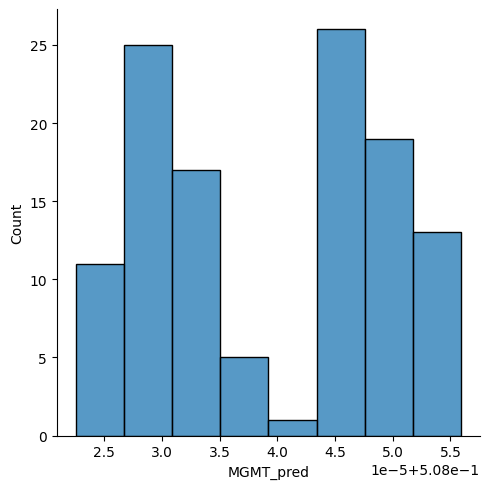

In [29]:
df_valid["MGMT_pred"] = 0
for m, mtype in zip(modelfiles,  mri_types):
    pred = predict(m, df_valid, mtype, "train")
    df_valid["MGMT_pred"] += pred["MGMT_value"]
df_valid["MGMT_pred"] /= len(modelfiles)
auc = roc_auc_score(df_valid["MGMT_value"], df_valid["MGMT_pred"])
print(f"Validation ensemble AUC: {auc:.4f}")

sns.displot(df_valid["MGMT_pred"])

### 6) Submission

In [30]:
submission = pd.read_csv(root_dir + "sample_submission.csv", index_col="BraTS21ID")
submission

,MGMT_value
BraTS21ID,
1,0.5
13,0.5
15,0.5
27,0.5
37,0.5
...,...
826,0.5
829,0.5
833,0.5


In [31]:
def refine_sub(dataframe):
    dataframe['BraTS21ID_full'] = [str(index).zfill(5) for index in dataframe.index]
    for i in range(len(mri_types)):
        mri = mri_types[i]
        dataframe[mri] = dataframe['BraTS21ID_full'].apply(lambda file_id: root_dir+'test/'+file_id+'/'+mri+'/')
    return dataframe

submission = refine_sub(submission)
submission

,MGMT_value,BraTS21ID_full,FLAIR,T1w,T1wCE,T2w
BraTS21ID,,,,,,
1,0.5,00001,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...
13,0.5,00013,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...
15,0.5,00015,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...
27,0.5,00027,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...
37,0.5,00037,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...
...,...,...,...,...,...,...
826,0.5,00826,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...
829,0.5,00829,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...
833,0.5,00833,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...


In [32]:
submission["MGMT_value"] = 0
for m, mtype in zip(modelfiles, mri_types):
    pred = predict(m, submission, mtype, "test")
    submission["MGMT_value"] += pred["MGMT_value"]

submission["MGMT_value"] /= len(modelfiles)
submission["MGMT_value"].to_csv("submission.csv")

Predict: FLAIR-best.pth FLAIR (87, 6)
Predict: T1w-best.pth T1w (87, 7)
Predict: T1wCE-best.pth T1wCE (87, 7)
Predict: T2w-best.pth T2w (87, 7)


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


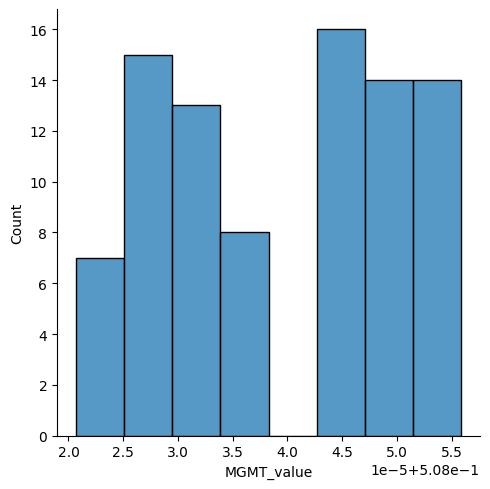

In [33]:
sns.displot(submission["MGMT_value"])

In [34]:
temp = pd.read_csv("submission.csv")
temp.head()

,BraTS21ID,MGMT_value
0,1,0.508055
1,13,0.508054
2,15,0.508051
3,27,0.508051
4,37,0.508053
